In [ ]:
# For kaggle 
DATASET_PATH = '/kaggle/input/'  # Path to source dataset
MASTER_PATH = '/kaggle/working/yolo_dataset/'  # Path where all outputs are stored (intermediate and final)

In [ ]:
#For google colab
import kagglehub
antoreepjana_animals_detection_images_dataset_path = kagglehub.dataset_download('antoreepjana/animals-detection-images-dataset')

print('Data source import complete.')

DATASET_PATH = '/root/.cache/kagglehub/datasets/antoreepjana/animals-detection-images-dataset/versions/7/'  # Path to source dataset
MASTER_PATH = '../kaggle/working/yolo_dataset/'  # Path where all outputs are stored (intermediate and final)

In [ ]:
# For window, linux or mac
!pip install kaggle
import os

DATASET_PATH = '../input/animals-detection-images-dataset/'  # Path to source dataset
MASTER_PATH = '../working/yolo_dataset/'  # Path where all outputs are stored (intermediate and final)

if not os.path.exists(DATASET_PATH):
    os.makedirs(DATASET_PATH)
    os.makedirs(MASTER_PATH)

import kaggle

kaggle.api.authenticate()
kaggle.api.dataset_download_files('antoreepjana/animals-detection-images-dataset', path=DATASET_PATH, unzip=True)

print('Data source import complete.')


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
!pip install ultralytics
!yolo checks

^C


"yolo" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


   ---------------------------------------- 0.0/904.3 kB ? eta -:--:--
   -- ------------------------------------- 61.4/904.3 kB 3.2 MB/s eta 0:00:01
   ------ --------------------------------- 153.6/904.3 kB 1.5 MB/s eta 0:00:01
   -------- ------------------------------- 194.6/904.3 kB 2.0 MB/s eta 0:00:01
   ------------------- -------------------- 450.6/904.3 kB 2.4 MB/s eta 0:00:01
   -------------------------- ------------- 604.2/904.3 kB 2.7 MB/s eta 0:00:01
   -------------------------------- ------- 727.0/904.3 kB 2.6 MB/s eta 0:00:01
   ---------------------------------------- 904.3/904.3 kB 2.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.4/38.8 MB 25.3 MB/s eta 0:00:02
    --------------------------------------- 0.7/38.8 MB 9.2 MB/s eta 0:00:05
   - -------------------------------------- 1.2/38.8 MB 9.2 MB/s eta 0:00:05
   - -------------------------------------- 1.4/38.8 MB 8.6 MB/s eta


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import shutil
import os
from typing import Dict, List
import matplotlib.pyplot as plt
import numpy as np

import cv2
from tqdm.notebook import tqdm
import torch
from ultralytics import YOLO

In [ ]:
def prepare_YOLO_weighted_dataset_not_multy_gpu():
    from ultralytics.data.dataset import YOLODataset
    import ultralytics.data.build as build

    class YOLOWeightedDataset(YOLODataset):
        def __init__(self, *args, mode = "train", **kwargs):
            """
            Initialize the WeightedDataset.

            Args:
                class_weights (list or numpy array): A list or array of weights corresponding to each class.
            """

            super(YOLOWeightedDataset, self).__init__(*args, **kwargs)

            self.train_mode = "train" in self.prefix

            # You can also specify weights manually instead
            self.count_instances()
            class_weights = np.sum(self.counts) / self.counts

            # Aggregation function
            self.agg_func = np.mean

            self.class_weights = np.array(class_weights)
            self.weights = self.calculate_weights()
            self.probabilities = self.calculate_probabilities()

        def count_instances(self):
            """
            Count the number of instances per class

            Returns:
                dict: A dict containing the counts for each class.
            """
            self.counts = [0 for i in range(len(self.data["names"]))]
            for label in self.labels:
                cls = label['cls'].reshape(-1).astype(int)
                for id in cls:
                    self.counts[id] += 1

            self.counts = np.array(self.counts)
            self.counts = np.where(self.counts == 0, 1, self.counts)

        def calculate_weights(self):
            """
            Calculate the aggregated weight for each label based on class weights.

            Returns:
                list: A list of aggregated weights corresponding to each label.
            """
            weights = []
            for label in self.labels:
                cls = label['cls'].reshape(-1).astype(int)

                # Give a default weight to background class
                if cls.size == 0:
                  weights.append(1)
                  continue

                # Take mean of weights
                # You can change this weight aggregation function to aggregate weights differently
                weight = self.agg_func(self.class_weights[cls])
                weights.append(weight)
            return weights

        def calculate_probabilities(self):
            """
            Calculate and store the sampling probabilities based on the weights.

            Returns:
                list: A list of sampling probabilities corresponding to each label.
            """
            total_weight = sum(self.weights)
            probabilities = [w / total_weight for w in self.weights]
            return probabilities

        def __getitem__(self, index):
            """
            Return transformed label information based on the sampled index.
            """
            # Don't use for validation
            if not self.train_mode:
                return self.transforms(self.get_image_and_label(index))
            else:
                index = np.random.choice(len(self.labels), p=self.probabilities)
                return self.transforms(self.get_image_and_label(index))


    build.YOLODataset = YOLOWeightedDataset

In [ ]:

# Use callbacks to monkey-patch

def prepare_YOLO_weighted_dataset_multy_gpu(trainer):
    from ultralytics.data.dataset import YOLODataset
    import ultralytics.data.build as build

    class YOLOWeightedDataset(YOLODataset):
        def __init__(self, *args, mode = "train", **kwargs):
            """
            Initialize the WeightedDataset.

            Args:
                  class_weights (list or numpy array): A list or array of weights corresponding to each class.
            """

            super(YOLOWeightedDataset, self).__init__(*args, **kwargs)

            self.train_mode = "train" in self.prefix

            # You can also specify weights manually instead
            self.count_instances()
            class_weights = np.sum(self.counts) / self.counts
            self.agg_func = np.mean

            self.class_weights = np.array(class_weights)
            self.weights = self.calculate_weights()
            self.probabilities = self.calculate_probabilities()

        def count_instances(self):
            """
            Count the number of instances per class

            Returns:
                dict: A dict containing the counts for each class.
            """
            self.counts = [0 for i in range(len(self.data["names"]))]
            for label in self.labels:
                cls = label['cls'].reshape(-1).astype(int)
                for id in cls:
                    self.counts[id] += 1

            self.counts = np.array(self.counts)
            self.counts = np.where(self.counts == 0, 1, self.counts)

        def calculate_weights(self):
            """
            Calculate the aggregated weight for each label based on class weights.

            Returns:
                list: A list of aggregated weights corresponding to each label.
            """
            weights = []
            for label in self.labels:
                cls = label['cls'].reshape(-1).astype(int)

                # Give a default weight to background class
                if cls.size == 0:
                    weights.append(1)
                    continue

                # Take mean of weights
                # You can change this weight aggregation function to aggregate weights differently
                # weight = np.mean(self.class_weights[cls])
                # weight = np.max(self.class_weights[cls])
                weight = self.agg_func(self.class_weights[cls])
                weights.append(weight)
            return weights

        def calculate_probabilities(self):
            """
            Calculate and store the sampling probabilities based on the weights.

            Returns:
                list: A list of sampling probabilities corresponding to each label.
            """
            total_weight = sum(self.weights)
            probabilities = [w / total_weight for w in self.weights]
            return probabilities

        def __getitem__(self, index):
            """
            Return transformed label information based on the sampled index.
            """
            # Don't use for validation
            if not self.train_mode:
                return self.transforms(self.get_image_and_label(index))
            else:
                index = np.random.choice(len(self.labels), p=self.probabilities)
                return self.transforms(self.get_image_and_label(index))

        build.YOLODataset = YOLOWeightedDataset

In [ ]:
DEBUG = False # Activete to run notebook faster


if torch.cuda.device_count() == 0:
    prepare_YOLO_weighted_dataset_not_multy_gpu()
    my_device = 'cpu'
elif torch.cuda.device_count() == 1:
    prepare_YOLO_weighted_dataset_not_multy_gpu()
    my_device = [0]
else:
    my_device = list(range(0, torch.cuda.device_count()))
print(my_device)
print(torch.cuda.device_count())

[0, 1]
2


In [1]:
class PreparationDatasetToYolo:
    """ The class is responsible for converting the dataset. """
    def __init__(self, input_path: str, output_path: str):

        """
        Designer.

        Args:
            input_path: input path
            output_path: output path
        """

        self.input_path = input_path
        self.output_path = output_path
        self.class_dictionary = self.create_dictionary(os.path.join(input_path, 'train'))


    def convert_datasets(self) -> None:
        """
        The main function. It converts the dataset.

        Args:
            is_train: this is an labels from the training dataset.
        """

        self.create_folder()
        self.create_config()
        self.convert_dataset()
        self.convert_dataset(False)


    def convert_dataset(self, is_train = True) -> None:
        """
        The convert dataset function. It converts train or test

        Args:
            is_train: this is an labels from the training dataset.
        """

        type_of_dataset = 'train' if is_train else 'test'
        input_train_path = os.path.join(self.input_path, type_of_dataset)
        for animal_class in tqdm(os.listdir(input_train_path)):
            animal_class_path = os.path.join(input_train_path, animal_class)
            number_image_of_class = 0
            for image in os.listdir(animal_class_path):
                if image == 'Label':
                    continue
                number_image_of_class += 1
                image_file = cv2.imread(os.path.join(animal_class_path, image))
                height_of_image, width_of_image, _ = image_file.shape
                self.prepare_image(os.path.join(animal_class_path, image), image, animal_class, number_image_of_class, is_train)
                self.prepare_labels(os.path.join(os.path.join(animal_class_path, 'Label'), image[:-4] + '.txt'), animal_class, number_image_of_class, height_of_image, width_of_image, is_train)


    def prepare_image(self, image_path: str, image_name: str, animal_class: str, number_image_of_class: int, is_train = True) -> None:
        """
        This function prepares image. Also it will have functions of augmentation.

        Args:
            image_path: path to input image.
            image_name: image name.
            animal_class: class of animal.
            number_image_of_class: number image of class.
            is_train: this is an image from the training dataset.
        """

        new_image_path = os.path.join(os.path.join(self.output_path, 'train' if is_train else 'test'), 'images')
        shutil.copy(image_path, new_image_path)
        shutil.move(os.path.join(new_image_path, image_name), os.path.join(new_image_path, animal_class + '_' + str(number_image_of_class) + '.jpg'))


    def prepare_labels(self, label_path: str, animal_class: str, number_image_of_class: int, height_of_image: int, width_of_image: int, is_train = True) -> None:
        """
        This function prepares labels. Also it will have functions of augmentation.

        Args:
            label_path: path to input labels.
            animal_class: class of animal.
            number_image_of_class: number image of class.
            height_of_image: height of image.
            width_of_image: width of image.
            is_train: this is an labels from the training dataset.
        """

        with open(label_path, 'r') as file:
            content = file.readlines()

        new_content = ''
        for line in content:
            line = line[:-2]
            line = line[::-1]
            list_data = line.split(' ', 4)[::-1]
            for i in range(len(list_data)):
                list_data[i] = list_data[i][::-1]

            self.class_dictionary[list_data[0]][1] = 1 + self.class_dictionary[list_data[0]][1]
            animal_class_index = self.class_dictionary[list_data[0]][0]
            x_center = (float(list_data[1]) + float(list_data[3])) / (2 * width_of_image)
            y_center = (float(list_data[2]) + float(list_data[4])) / (2 * height_of_image)
            width = (float(list_data[3]) - float(list_data[1])) / width_of_image
            height = (float(list_data[4]) - float(list_data[2])) / height_of_image
            new_content += str(animal_class_index) + ' ' + str(x_center) + ' ' + str(y_center) + ' ' + str(width) + ' ' + str(height) + '\n'
            new_label_path = os.path.join(os.path.join(os.path.join(self.output_path, 'train' if is_train else 'test'), 'labels'), animal_class + '_' + str(number_image_of_class) + '.txt')

        with open(new_label_path, 'w') as file:
            file.write(new_content)


    def create_dictionary(self, classes_path: str) -> dict[str, int]:
        """
        This function creates dictionary, which has copels of class and his index (number from 0 to number of classes - 1)

        Args:
            classes_path: path to directory listing classes.

        Returns:
            Dictionary, which has copels of class and his index (number from 1 to number of classes)
        """

        return {animal_class: [index, 0] for index, animal_class in enumerate(os.listdir(classes_path))}


    def create_folder(self) -> None:

        """
        This function create folders for prepared data.
        """

        os.makedirs(self.output_path)
        os.makedirs(os.path.join(self.output_path, 'graphs'))
        os.makedirs(os.path.join(self.output_path, 'train'))
        os.makedirs(os.path.join(self.output_path, 'test'))
        os.makedirs(os.path.join(os.path.join(self.output_path, 'train'), 'images'))
        os.makedirs(os.path.join(os.path.join(self.output_path, 'test'), 'images'))
        os.makedirs(os.path.join(os.path.join(self.output_path, 'train'), 'labels'))
        os.makedirs(os.path.join(os.path.join(self.output_path, 'test'), 'labels'))


    def build_histogram_of_classes_number(self) -> None:

        """
        This function build histogram of classes number
        """

        count_animals_in_classes = [pair[1] for pair in self.class_dictionary.values()]
        fig, ax = plt.subplots(figsize=(15, 6))
        ax.bar(self.class_dictionary.keys(), count_animals_in_classes, color='skyblue')
        plt.title('Гистограмма количества объектов по классам')
        plt.xlabel('Классы')
        plt.ylabel('Количество объектов')
        plt.xticks(rotation=90)
        plt.show()
        fig.savefig(os.path.join(os.path.join(self.output_path, 'graphs'), 'histogram_of_number_of_elements_in_classes.pdf'),
                                dpi = 300,
                                bbox_inches = 'tight')


    def create_config(self) -> None:
        """
        This function creates config file, which has basic information.
        """

        content = "names:\n"
        for animal_class in list(self.class_dictionary.keys()):
            content += ('- ' + animal_class + '\n')
        content += ('nc: ' + str(self.class_dictionary[list(self.class_dictionary.keys())[-1]][0] + 1) + '\n')
        content += ('path: ' + self.output_path + '\n')
        content += 'train: train/images\n'
        content += 'val: test/images\n'

        with open(os.path.join(self.output_path, 'config.yaml'), 'w') as file:
            file.write(content)


    def delete_datasets(self) -> None:
        """
        This function deletes datasets directory (output_path)
        """

        shutil.rmtree(self.output_path)

In [ ]:
changer = PreparationDatasetToYolo(
    input_path = DATASET_PATH,
    output_path = MASTER_PATH
)

if os.path.exists(MASTER_PATH):
    changer.delete_datasets()

changer.convert_datasets()

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

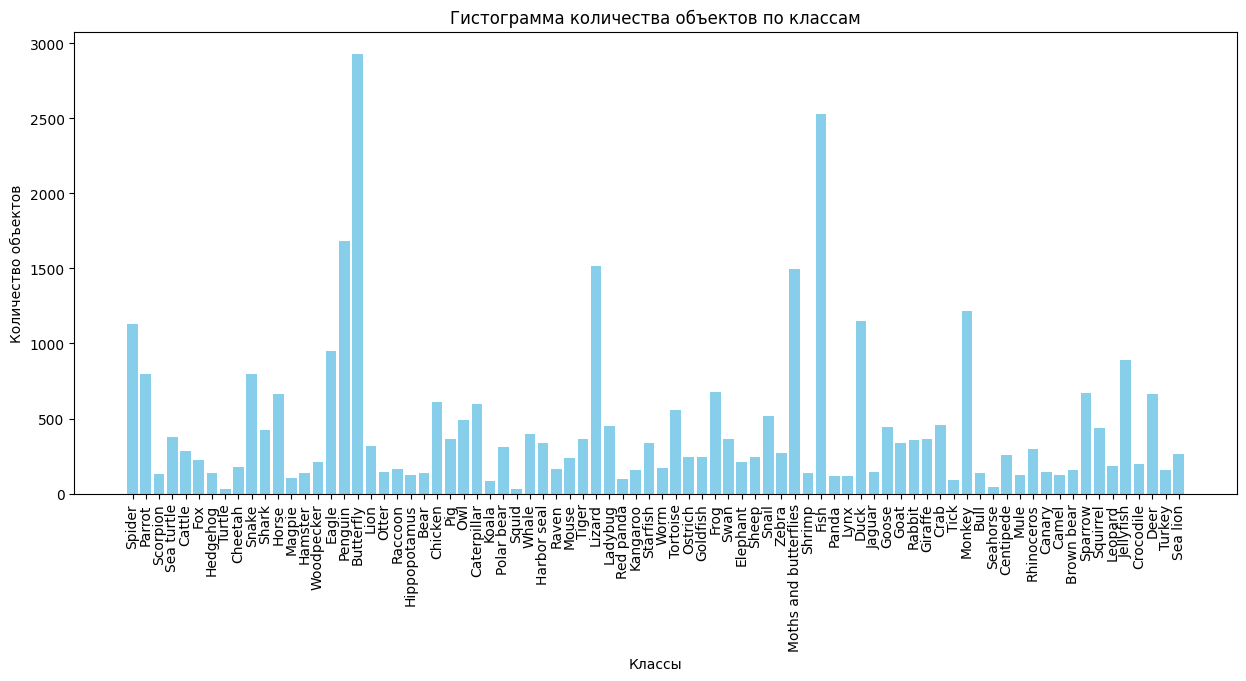

In [ ]:
changer.build_histogram_of_classes_number()

In [ ]:
model = YOLO('yolo11n.pt')
if torch.cuda.device_count() >= 2:
    model.add_callback("on_pretrain_routine_start", prepare_YOLO_weighted_dataset_multy_gpu)

results = model.train(
    data = os.path.join(MASTER_PATH, 'config.yaml'),
    epochs = 50 if not DEBUG else 1,
    optimizer = 'NAdam',
    val = True,
    batch = 96,
    imgsz = 640,
    device = my_device,
    lr0 = 0.001,
    lrf = 0.0005,
    project = 'model_NAdam',
    name = 'Test_NAdam_50_epoch_96',
    save = True,
    save_period = 1
)

results = model.val()

print(results)

100%|██████████| 5.35M/5.35M [00:00<00:00, 76.6MB/s]


Ultralytics 8.3.49 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
                                                 CUDA:1 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/kaggle/working/yolo_dataset/config.yaml, epochs=50, time=None, patience=100, batch=96, imgsz=640, save=True, save_period=1, cache=False, device=[0, 1], workers=8, project=model_NAdam, name=Test_NAdam_50_epoch_96, exist_ok=False, pretrained=True, optimizer=NAdam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, sa

100%|██████████| 755k/755k [00:00<00:00, 17.4MB/s]



                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

train: Scanning /kaggle/working/yolo_dataset/train/labels... 22566 images, 0 backgrounds, 0 corrupt: 100%|██████████| 22566/22566 [00:31<00:00, 722.75it/s] 


train: WARNING ⚠️ /kaggle/working/yolo_dataset/train/images/Giraffe_259.jpg: 1 duplicate labels removed
train: New cache created: /kaggle/working/yolo_dataset/train/labels.cache


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/yolo_dataset/test/labels...:   0%|          | 0/6505 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/yolo_dataset/test/labels... 3302 images, 0 backgrounds, 0 corrupt:  51%|█████     | 3302/6505 [00:02<00:02, 1092.63it/s]/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /kaggle/working/yolo_dataset/test/labels... 6505 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6505/6505 [00:05<00:00, 1157.00it/s]


val: New cache created: /kaggle/working/yolo_dataset/test/labels.cache
Plotting labels to model_NAdam/Test_NAdam_50_epoch_96/labels.jpg... 
optimizer: NAdam(lr=0.001, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.00075), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to model_NAdam/Test_NAdam_50_epoch_96
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      9.93G     0.9944      2.678      1.347          8        640: 100%|██████████| 236/236 [04:16<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:51<00:00,  1.32it/s]


                   all       6505       7576      0.453      0.117      0.085      0.045

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      8.72G      1.015      2.045       1.36          6        640: 100%|██████████| 236/236 [04:17<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:52<00:00,  1.31it/s]


                   all       6505       7576      0.353      0.189      0.131      0.093

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      8.67G      1.048      2.017      1.378          9        640: 100%|██████████| 236/236 [04:05<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:45<00:00,  1.48it/s]


                   all       6505       7576      0.324      0.224      0.145      0.096

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      9.05G      1.033      1.919      1.368          9        640: 100%|██████████| 236/236 [03:55<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:44<00:00,  1.52it/s]


                   all       6505       7576      0.285      0.175      0.116     0.0754

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      9.38G     0.9913      1.793      1.339         11        640: 100%|██████████| 236/236 [03:52<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:47<00:00,  1.45it/s]


                   all       6505       7576        0.4      0.175       0.14      0.103

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      9.58G     0.9732      1.703      1.327          7        640: 100%|██████████| 236/236 [03:57<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:45<00:00,  1.49it/s]


                   all       6505       7576      0.394      0.261      0.218      0.154

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      8.96G     0.9465      1.631      1.304         12        640: 100%|██████████| 236/236 [03:57<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:46<00:00,  1.45it/s]


                   all       6505       7576      0.433      0.376      0.321       0.24

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50       8.3G     0.9179      1.551      1.297          9        640: 100%|██████████| 236/236 [04:00<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:46<00:00,  1.45it/s]


                   all       6505       7576      0.448      0.382      0.353      0.274

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      8.89G     0.9339      1.534      1.296         12        640: 100%|██████████| 236/236 [03:57<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:46<00:00,  1.47it/s]


                   all       6505       7576      0.453      0.411      0.382      0.295

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      8.71G      0.914       1.48      1.285          8        640: 100%|██████████| 236/236 [03:58<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:45<00:00,  1.48it/s]


                   all       6505       7576      0.438      0.361      0.336      0.258

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      8.45G     0.9032      1.449      1.279          7        640: 100%|██████████| 236/236 [03:58<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:46<00:00,  1.46it/s]


                   all       6505       7576      0.492      0.414      0.408      0.319

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      10.1G     0.8915      1.423      1.273         12        640: 100%|██████████| 236/236 [03:57<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:46<00:00,  1.48it/s]


                   all       6505       7576       0.47      0.396      0.379      0.296

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      8.97G     0.8846      1.379      1.268          8        640: 100%|██████████| 236/236 [03:55<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:46<00:00,  1.46it/s]


                   all       6505       7576       0.53      0.397      0.407      0.323

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      8.89G     0.8832      1.362      1.264          8        640: 100%|██████████| 236/236 [03:58<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:45<00:00,  1.48it/s]


                   all       6505       7576       0.46      0.461      0.424      0.337

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      9.06G     0.8688      1.342      1.253         10        640: 100%|██████████| 236/236 [03:56<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:46<00:00,  1.47it/s]


                   all       6505       7576       0.52      0.465      0.466      0.376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      9.02G     0.8647      1.321      1.253         25        640: 100%|██████████| 236/236 [03:53<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:44<00:00,  1.52it/s]


                   all       6505       7576      0.514      0.494      0.483      0.382

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50       9.6G     0.8678      1.288      1.245         10        640: 100%|██████████| 236/236 [03:53<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:46<00:00,  1.46it/s]


                   all       6505       7576      0.541      0.502      0.511      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      9.71G     0.8584      1.261      1.243         12        640: 100%|██████████| 236/236 [03:54<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:45<00:00,  1.49it/s]


                   all       6505       7576      0.521      0.537       0.52      0.421

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      9.34G     0.8552      1.254      1.245          5        640: 100%|██████████| 236/236 [03:55<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:44<00:00,  1.53it/s]


                   all       6505       7576      0.551        0.5      0.502      0.408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      8.38G     0.8371      1.236      1.238          7        640: 100%|██████████| 236/236 [03:57<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:47<00:00,  1.44it/s]


                   all       6505       7576      0.539      0.541      0.532      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      9.22G     0.8408        1.2      1.227         11        640: 100%|██████████| 236/236 [03:56<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:45<00:00,  1.49it/s]


                   all       6505       7576      0.553      0.542      0.531      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50       9.3G     0.8451      1.204      1.234          6        640: 100%|██████████| 236/236 [03:54<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:44<00:00,  1.53it/s]


                   all       6505       7576       0.57      0.501      0.517      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50       9.7G     0.8391       1.19      1.236          7        640: 100%|██████████| 236/236 [03:53<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:45<00:00,  1.50it/s]


                   all       6505       7576      0.558       0.56      0.545       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:45<00:00,  1.49it/s]


                   all       6505       7576      0.561      0.529      0.548      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      9.38G     0.8235      1.139       1.22          7        640: 100%|██████████| 236/236 [03:55<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:46<00:00,  1.48it/s]


                   all       6505       7576      0.552      0.549      0.558      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      9.64G     0.8187      1.133      1.216          7        640: 100%|██████████| 236/236 [03:58<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:45<00:00,  1.49it/s]


                   all       6505       7576      0.593      0.579      0.576      0.481

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      8.95G     0.8285      1.134      1.222          9        640: 100%|██████████| 236/236 [03:56<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:48<00:00,  1.41it/s]


                   all       6505       7576      0.575      0.574      0.583      0.481

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      8.94G     0.8117      1.107      1.212          8        640: 100%|██████████| 236/236 [03:54<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:45<00:00,  1.48it/s]


                   all       6505       7576      0.606      0.574      0.588       0.49

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      9.57G     0.8189      1.097      1.215         12        640: 100%|██████████| 236/236 [03:53<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:45<00:00,  1.48it/s]


                   all       6505       7576      0.588      0.595      0.598      0.498

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      9.44G      0.808      1.093      1.208          6        640: 100%|██████████| 236/236 [03:53<00:00,  1.01it/s]
      31/50      8.92G     0.8007      1.064      1.204         14        640: 100%|██████████| 236/236 [03:55<00:00,  1.00it/s]1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:45<00:00,  1.50it/s]


                   all       6505       7576      0.583      0.586       0.59      0.501

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      8.54G     0.7972      1.056      1.206          5        640: 100%|██████████| 236/236 [03:55<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:46<00:00,  1.48it/s]


                   all       6505       7576      0.593      0.612      0.611      0.517

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      8.84G     0.7853      1.045      1.196          8        640: 100%|██████████| 236/236 [03:58<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:44<00:00,  1.53it/s]


                   all       6505       7576      0.605       0.59      0.606      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      8.88G     0.7848      1.022      1.194          6        640: 100%|██████████| 236/236 [03:57<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:45<00:00,  1.49it/s]


                   all       6505       7576      0.574      0.642      0.617      0.524

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50        10G     0.7872      1.006      1.189         12        640: 100%|██████████| 236/236 [03:56<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:44<00:00,  1.51it/s]


                   all       6505       7576      0.612      0.627      0.618      0.525

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      8.38G     0.7753     0.9964      1.187         10        640: 100%|██████████| 236/236 [03:56<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:46<00:00,  1.45it/s]


                   all       6505       7576      0.614      0.619      0.623      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      9.29G     0.7643     0.9808      1.182         11        640: 100%|██████████| 236/236 [03:59<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:46<00:00,  1.48it/s]


                   all       6505       7576      0.606       0.63      0.631      0.538

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      10.3G     0.7727     0.9674      1.182          6        640: 100%|██████████| 236/236 [03:57<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:45<00:00,  1.49it/s]


                   all       6505       7576      0.608      0.623      0.633      0.539

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      8.76G     0.7612      0.957      1.181          6        640: 100%|██████████| 236/236 [03:57<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:48<00:00,  1.40it/s]


                   all       6505       7576      0.631      0.629      0.641      0.547

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      9.33G     0.7658     0.9438      1.174         10        640: 100%|██████████| 236/236 [03:58<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:44<00:00,  1.51it/s]


                   all       6505       7576      0.608      0.649      0.644      0.553
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      8.74G     0.6548     0.6374      1.124          3        640: 100%|██████████| 236/236 [03:49<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:45<00:00,  1.49it/s]


                   all       6505       7576      0.609      0.636      0.634      0.543

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      8.74G     0.6393     0.5991      1.111          3        640: 100%|██████████| 236/236 [03:45<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:46<00:00,  1.47it/s]


                   all       6505       7576       0.59      0.643      0.638      0.545

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      8.78G      0.628     0.5967      1.101          8        640: 100%|██████████| 236/236 [03:44<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:45<00:00,  1.50it/s]


                   all       6505       7576      0.605      0.628      0.638      0.547

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      9.52G     0.6196     0.5609      1.094          4        640: 100%|██████████| 236/236 [03:47<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:44<00:00,  1.51it/s]


                   all       6505       7576      0.608      0.639      0.639       0.55

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      8.83G     0.5978     0.5307      1.076          3        640: 100%|██████████| 236/236 [03:49<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:45<00:00,  1.50it/s]


                   all       6505       7576      0.602      0.643      0.639       0.55

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      9.72G     0.6081     0.5318      1.079          4        640: 100%|██████████| 236/236 [03:46<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:45<00:00,  1.50it/s]


                   all       6505       7576      0.611      0.643      0.642      0.552

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      9.86G     0.6106     0.5118      1.074          3        640: 100%|██████████| 236/236 [03:46<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:46<00:00,  1.47it/s]


                   all       6505       7576      0.603       0.66      0.644      0.555

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      10.1G      0.589     0.4911      1.071          3        640: 100%|██████████| 236/236 [03:46<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:45<00:00,  1.49it/s]


                   all       6505       7576      0.611      0.643      0.643      0.553

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      8.64G     0.5768     0.4663      1.056          3        640: 100%|██████████| 236/236 [03:47<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:45<00:00,  1.50it/s]


                   all       6505       7576      0.605      0.645      0.644      0.554

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      8.02G     0.5693     0.4573      1.055          3        640: 100%|██████████| 236/236 [03:47<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:45<00:00,  1.48it/s]


                   all       6505       7576      0.593      0.649      0.643      0.554

50 epochs completed in 3.935 hours.
Optimizer stripped from model_NAdam/Test_NAdam_50_epoch_96/weights/last.pt, 5.5MB
Optimizer stripped from model_NAdam/Test_NAdam_50_epoch_96/weights/best.pt, 5.5MB

Validating model_NAdam/Test_NAdam_50_epoch_96/weights/best.pt...
Ultralytics 8.3.49 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
                                                 CUDA:1 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 238 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:46<00:00,  1.45it/s]


                   all       6505       7576      0.606      0.657      0.644      0.554
                Spider        207        213      0.898      0.939       0.97       0.87
                Parrot        180        203      0.852      0.851      0.909      0.796
              Scorpion         44         44      0.884      0.864       0.94      0.822
            Sea turtle         87        104      0.429      0.471      0.384      0.331
                Cattle        171        209      0.652      0.388      0.496       0.44
                   Fox         69         72       0.78      0.875      0.906      0.844
              Hedgehog         49         52      0.792      0.904      0.909      0.784
                Turtle          5          7      0.682      0.143      0.149      0.132
               Cheetah         35         39      0.432       0.59      0.439      0.396
                 Snake        213        219      0.836      0.904      0.916      0.767
                 Shar

val: Scanning /kaggle/working/yolo_dataset/test/labels.cache... 6505 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6505/6505 [00:00<?, ?it/s]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [00:50<00:00,  1.34it/s]


                   all       6505       7576      0.604      0.659      0.644      0.555
                Spider        207        213      0.898      0.939       0.97      0.869
                Parrot        180        203      0.852      0.852      0.909      0.796
              Scorpion         44         44      0.883      0.864       0.94      0.821
            Sea turtle         87        104      0.428      0.471      0.386      0.332
                Cattle        171        209      0.646      0.388      0.498      0.441
                   Fox         69         72       0.78      0.875      0.905       0.84
              Hedgehog         49         52       0.79      0.904      0.909      0.784
                Turtle          5          7      0.653      0.143      0.149      0.132
               Cheetah         35         39      0.425       0.59      0.442        0.4
                 Snake        213        219      0.834      0.909      0.917      0.768
                 Shar